## Drifters and Cmems data Notebook

### Introduction
This notebook aims to interpolate the wind field from CMEMS onto the drifter positions and calculate the surface Ekman current, and then add it to the geostrophic current.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: SEALEVEL_GLO_PHY_L4_MY_008_047

### Tasks

#### 1. Interpolation and Ekman current

- Interpolating the wind field from CMEMS onto the drifter positions and calculating the surface Ekman current.

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (DUACS current) and conclusion.


#### 1. Interpolation and Ekman current

## Import Library

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data

In [2]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables

In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data

In [5]:
# Test: Our selected drifter has 1102 observations. 
 
df_1 = df[0:500]
df_1

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
495,-22.450,-17.101,2023-05-04 18:00:00,0.02080,0.00505,26.874
496,-22.443,-17.101,2023-05-05 00:00:00,0.03049,0.02243,26.792
497,-22.437,-17.092,2023-05-05 06:00:00,0.02100,0.03648,26.749
498,-22.435,-17.087,2023-05-05 12:00:00,-0.00296,0.03702,26.820


## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity ugosa and  vgosa

In [6]:
# Loading drifting buoy data from the DataFrame
df_bouees = df[0:500] 
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude'

# Loading satellite data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1713524113026.nc') 
# Suppose your satellite data is stored in variables called 'ugosa' and 'vgosa'

# Extracting satellite current data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgosa'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

In [8]:
ds_satellitaires = xr.open_dataset('cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc')   
ds_satellitaires

<xarray.Dataset>
Dimensions:              (time: 6, latitude: 160, longitude: 360)
Coordinates:
  * latitude             (latitude) float32 -19.88 -19.62 -19.38 ... 19.62 19.88
  * longitude            (longitude) float32 -69.88 -69.62 ... 19.62 19.88
  * time                 (time) datetime64[ns] 2023-01-01 ... 2023-06-01
Data variables:
    eastward_wind        (time, latitude, longitude) float32 ...
    eastward_wind_bias   (time, latitude, longitude) float32 ...
    northward_wind       (time, latitude, longitude) float32 ...
    northward_wind_bias  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:              Global Ocean - Wind and Stress - Monthly - From Scatt...
    institution:       Royal Netherlands Meteorological Institute (KNMI)
    history:           N/A
    references:        Copernicus Marine Service Product User Manual CMEMS-WI...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  WIND_GLO_PHY_CLIMATE_L4_MY_012_003
    subset:datasetId:  cmems_obs-wind_glo_phy_my_l4_P1M_202211
    subset:date:       2024-05-13T00:57:10.440Z

### Case of east-West and North-South Component of 10m Surface Wind(u_mean) and (v_mean)

In [9]:
# Loading drifting buoy data from the DataFrame
df_bouees = df[0:500]   
# Suppose your DataFrame contains columns 'time', 'latitude', and 'longitude' 

# Loading satellite wind data from the netCDF file
ds_satellitaires = xr.open_dataset('cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc')   
# Suppose your satellite wind data is stored in variables called 'eastward_wind' and 'northward_wind'

# Extracting satellite wind data for the same spatial and temporal positions as the buoys
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellite_wind_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['eastward_wind'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_wind_u.append(courant)

satellite_wind_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['northward_wind'].interp(latitude=lat, longitude=lon, time=time).values
    satellite_wind_v.append(courant)

## Calculation of surface Ekman current

## Calculation of Ekman current:

The speed of Ekman current can be calculated using the Ekman equation:
$$
V_{Ek} = \frac{{1}}{{\rho fH}} \cdot \nabla \times \tau 
$$
Where:
- $ V_{Ek}$ is the Ekman current.
- $ \tau $ is the wind stress, which is the force exerted by the wind on the water surface.
- $ \rho $ is the water density.
- $ f $ is the Coriolis parameter, which depends on latitude.

The formula for wind stress can be expressed as follows:

$$ \tau = \rho_a \cdot C_d \cdot \| \text{V} \| \cdot \text{V} $$

where :

- $\rho_a$ is the air density (in $ \text{kg/m}^3 $),
- $ C_d $ is the drag coefficient (dimensionless),
- $\| \text{V} \|$ is the magnitude of the wind velocity vector (in $ \text{m/s} $),
- $\text{V} $ is the wind velocity vector,
- $\tau$ is in $N/m^{2}$

In [11]:
def calculate_magnitude(V_x, V_y):
    """
    Calculate the magnitude of vector V from its components V_x and V_y.
    """
    return np.sqrt(V_x*V_x + V_y*V_y)

def calculate_wind_stress(rho_a, C_d, V_x, V_y):
    """
    Calculate the components of wind stress (tau_x and tau_y)
    based on air density (rho_a), drag coefficient (C_d),
    and components of the wind velocity vector (V_x and V_y).
    """
    # Calculate the magnitude of the wind velocity vector
    V_magnitude = calculate_magnitude(V_x, V_y)
    
    # Calculate the components of wind stress
    tau_x = rho_a * C_d * V_magnitude * V_x
    tau_y = rho_a * C_d * V_magnitude * V_y
    
    return tau_x, tau_y

# Example usage with arbitrary values
rho_a = 1.225  # Air density in kg/m^3
C_d = 0.001  # Drag coefficient
V_x = satellite_wind_u  # Horizontal component of wind velocity (time x latitude x longitude)
V_y = satellite_wind_v  # Vertical component of wind velocity (time x latitude x longitude)
V_x = np.array(V_x)     # Convert lists V_x and V_x into an array
V_y = np.array(V_y)     #

tau_x, tau_y = calculate_wind_stress(rho_a, C_d, V_x, V_y)

#print("Horizontal component of wind stress (tau_x):", tau_x, "N/m^2")
#print("Vertical component of wind stress (tau_y):", tau_y, "N/m^2")

In [12]:
# Calculate wind shear components tau_x and tau_y
H = 15  # Depth of the Ekman layer
rho = 1025   # Density of water (kg/m^3)  

# Calculate the Coriolis parameter f based on latitudes
f = 2 * np.pi * 7.29e-5 * np.sin(np.deg2rad(latitudes))

# Calculate Ekman current components
u_e_sat =  tau_y / (f*rho*H)
v_e_sat =  tau_x / (-f*rho*H)

# Display results
#print("Component x of Ekman current (u_e):", u_e_sat)
#print("Component y of Ekman current (v_e):", v_e_sat)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (CMEMS current) and conclusion.

## ugosa plus Ekman zonal current

In [13]:
# u_total = u_geostro + u_e_sat
u_total = satellitaires_courant_u + u_e_sat

## v_current plus Ekman meridional current

In [14]:
# u_total = v_geostro + v_e_sat
v_total = satellitaires_courant_v + v_e_sat

## Creation of Pandas Array for NOAA total current Data

In [15]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF

,u_total,v_total
0,-0.075314,-0.030467
1,-0.074744,-0.028341
2,-0.077655,-0.027238
3,-0.081981,-0.024658
4,-0.082523,-0.020664
...,...,...
495,0.030977,-0.006501
496,0.030732,-0.007584
497,0.029994,-0.008589
498,0.029583,-0.009362


## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and u_total of CMEMS

## Using Regression and Correlation

Corrélation de Pearson: 0.5317847428215654
Valeur de p (p-value): 7.592375885673876e-38


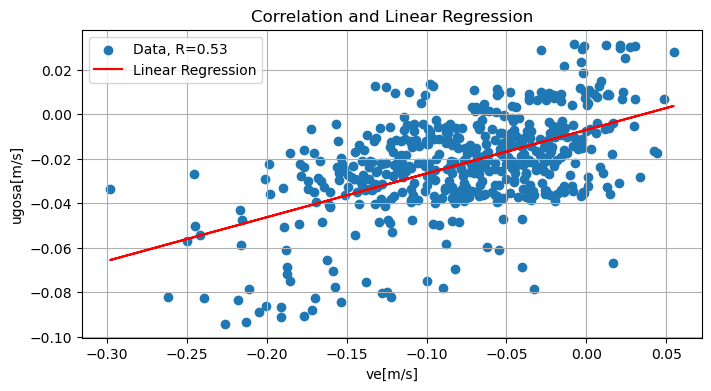

In [16]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.53. 
# This means Moderate inverse relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_1['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve[m/s]')
plt.ylabel('ugosa[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_e$ and $u_total$

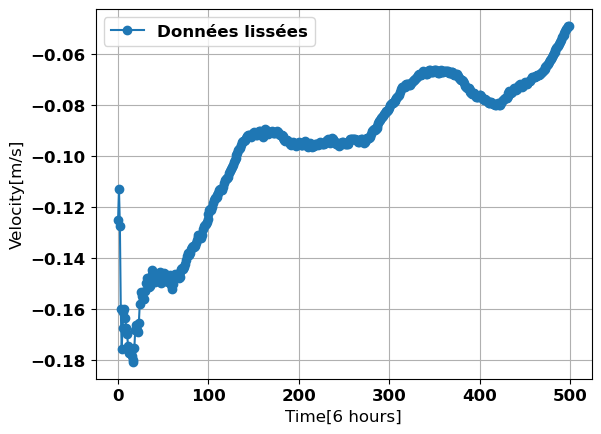

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle = bouees_courant_u

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_1 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_1.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_1, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $u_total$

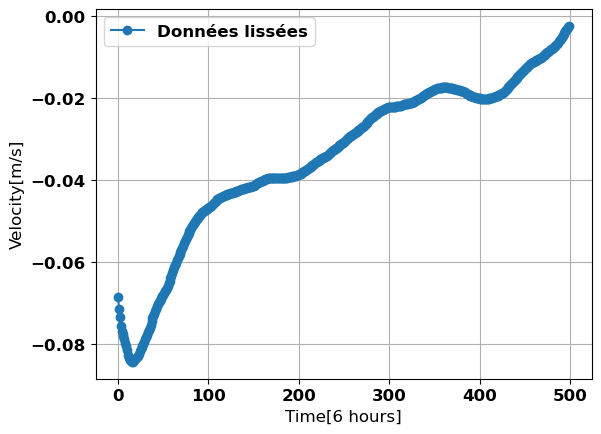

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle = dF['u_total']

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_2 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_2.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_2, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

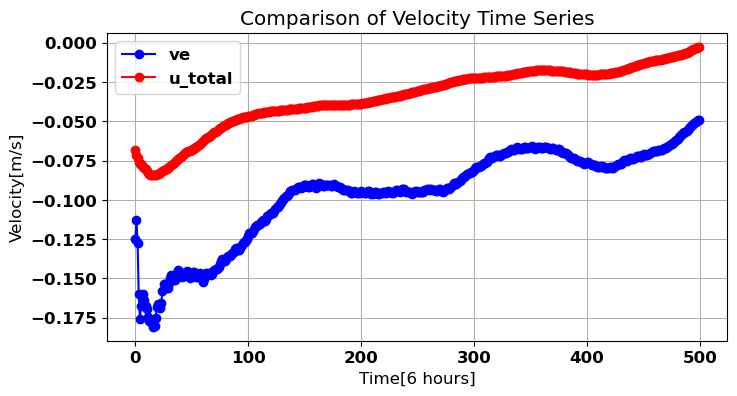

In [19]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(filtered_values_2, color='RED', marker='o', linestyle='-', label='u_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Comparison between vn and v_total of CMEMS

## Using Regression and Correlation

Corrélation de Pearson: 0.21495413562527868
Valeur de p (p-value): 1.2264649860075673e-06


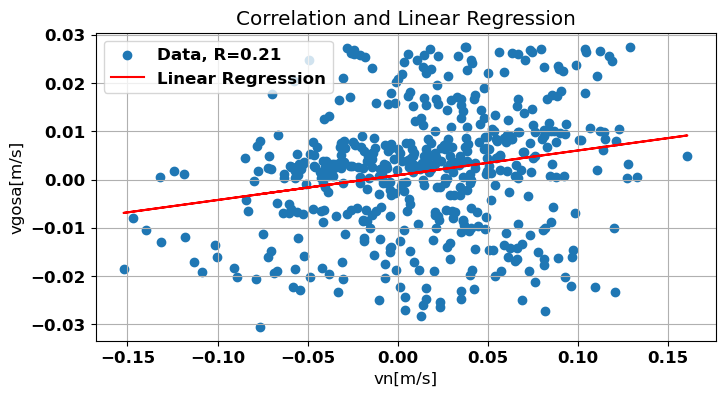

In [21]:
from scipy.stats import pearsonr

# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.21. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_1['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn[m/s]')
plt.ylabel('vgosa[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_n$ and $v_total$

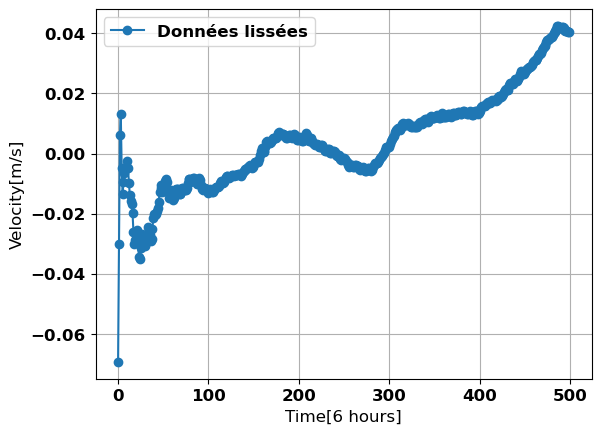

In [22]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle = bouees_courant_v

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_3 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_3.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_3, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $v_total$

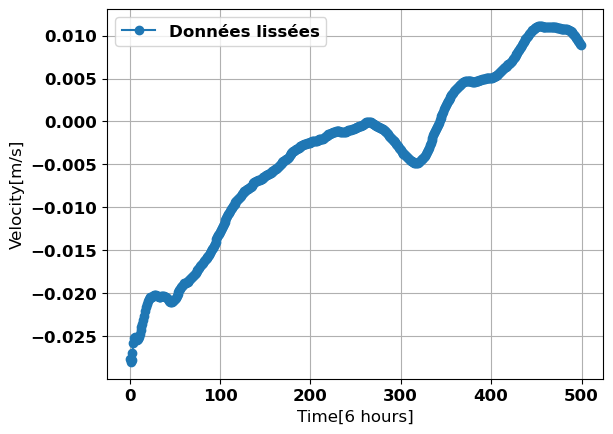

In [24]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle = dF['v_total']

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_4 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_4.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_4, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

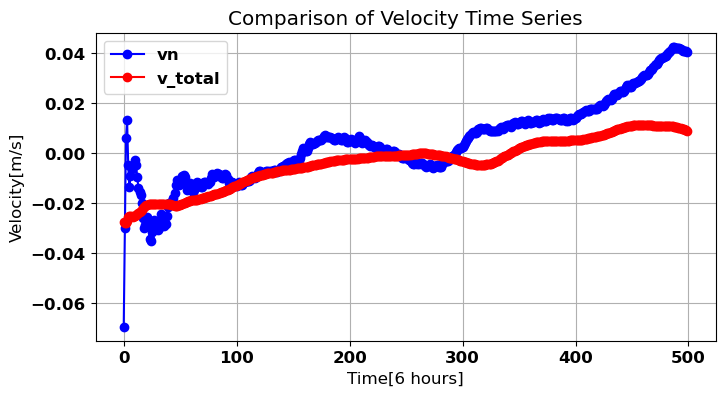

In [25]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(filtered_values_4, color='RED', marker='o', linestyle='-', label='v_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

### The use of Kalman filter for smoothing $ugosa$ and $vgosa$

### Case of ugosa 

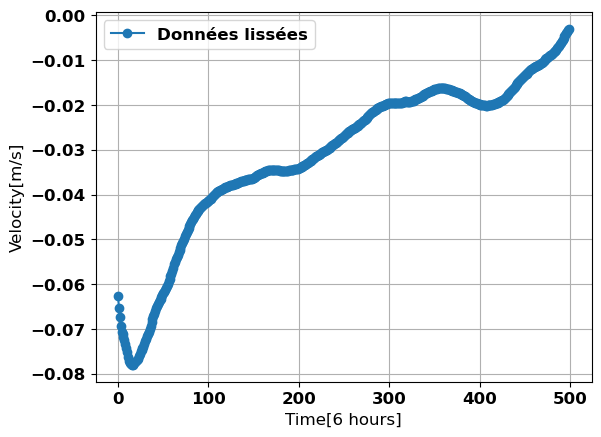

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  satellitaires_courant_u

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_5 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_5.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_5, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of vgosa 

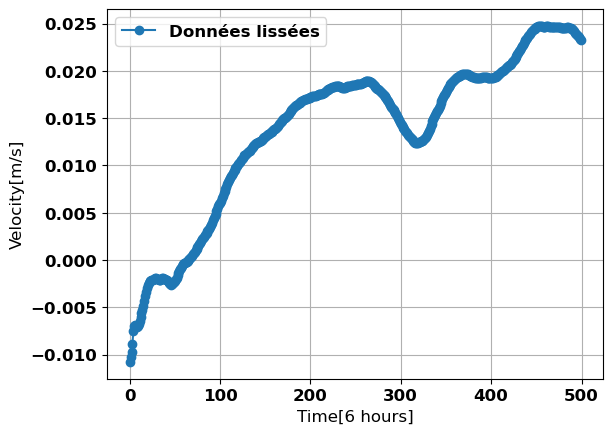

In [27]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  satellitaires_courant_v

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_6 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_6.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_6, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of u_e_sat (u_ekman)

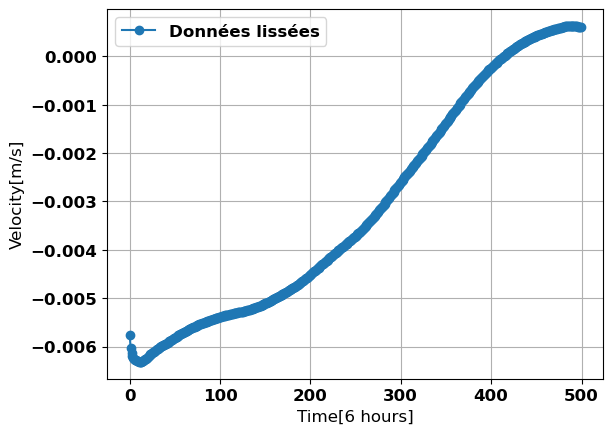

In [28]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  u_e_sat

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_7 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_7.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_7, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Case of v_e_sat (v_ekman)

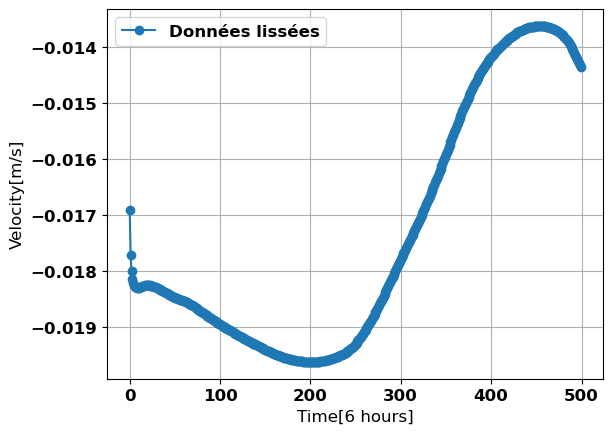

In [29]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Load the time series
# Suppose your time series is in a numpy array called "time_series"
# Replace "time_series.npy" with the name of your file containing the time series
serie_temporelle =  v_e_sat

# Kalman filter parameters
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialize the Kalman filter
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Smooth the time series using the Kalman filter
filtered_values_8 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_8.append(kf.get_latest_estimated_measurement())

# Plot the original and smoothed data
#plt.plot(df['time'], time_series, marker='o', linestyle='-', label='Original Data')
plt.plot(filtered_values_8, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

### Resume

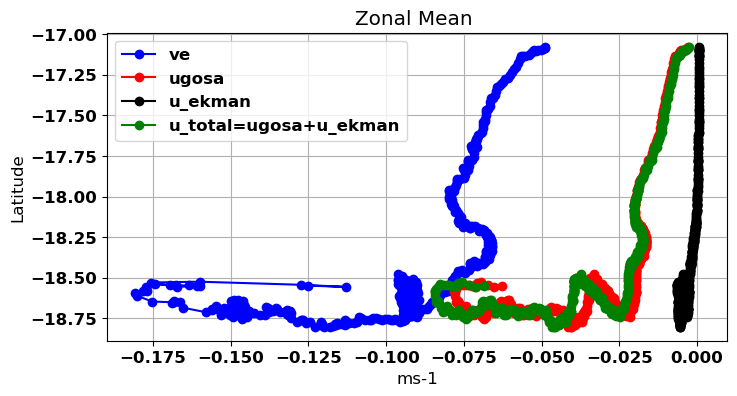

In [30]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, df_1['latitude'],marker='o', linestyle='-', color='blue',label='ve')
plt.plot(filtered_values_5, df_1['latitude'],marker='o', linestyle='-', color='red',label='ugosa')
plt.plot(filtered_values_7, df_1['latitude'],marker='o', linestyle='-', color='k',label='u_ekman')
plt.plot(filtered_values_2, df_1['latitude'],marker='o', linestyle='-', color='g',label='u_total=ugosa+u_ekman')

plt.title('Zonal Mean ')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

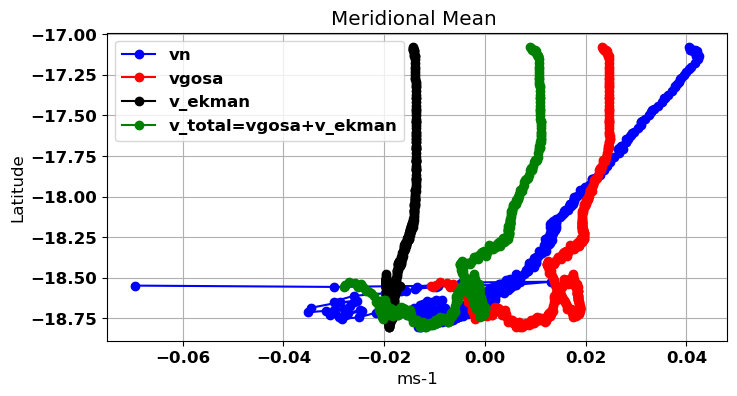

In [31]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, df_1['latitude'],marker='o', linestyle='-', color='blue',label='vn')
plt.plot(filtered_values_6, df_1['latitude'],marker='o', linestyle='-', color='red',label='vgosa')
plt.plot(filtered_values_8, df_1['latitude'],marker='o', linestyle='-', color='k',label='v_ekman')
plt.plot(filtered_values_4, df_1['latitude'],marker='o', linestyle='-', color='g',label='v_total=vgosa+v_ekman')

plt.title('Meridional Mean ')
plt.xlabel('ms-1')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

## Module of Currents

In [32]:
# Define vectors u, v, w, and z

u = np.array(filtered_values_1 ) # u=ve  zonal current drifter
v = np.array(filtered_values_3  ) # v=ve  meridional current drifter
w = np.array(filtered_values_2) # w=u_total 
z = np.array(filtered_values_4) # z=v_total

# Calcul des normes entre u et v, et entre w et z
# norme_uv = np.sqrt(np.sum((u - v)**2))
# norme_wz = np.sqrt(np.sum((w - z)**2))

# Calcul des modules de u, v, w et z
module_u = np.linalg.norm(u)
module_v = np.linalg.norm(v)
module_w = np.linalg.norm(w)
module_z = np.linalg.norm(z)

# Affichage des modules
print("Module de ve :", module_u)
print("Module de vn :", module_v)
print("Module de u_total :", module_w)
print("Module de v_total :", module_z) 

Module de ve : 2.2496439013639917
Module de vn : 0.3767525049631069
Module de u_total : 0.8872307523221588
Module de v_total : 0.23580165945178463


## Conclusion
- The geostrophic current dominates both the zonal and meridional directions. The Ekman current calculated from CMEMS wind data is dominated by the meridional component. The magnitude of the total zonal and meridional drifter current is much higher compared to that of the satellite.
- By adding the Ekman current to the zonal and meridional geostrophic currents from CMEMS satellites, we observe a clear improvement in the satellite current, which tends to approach more and more closely to that of our drifters.
 